In [1]:
import numpy as np 
import pandas as pd 

In [2]:
# For tick data
df_hf = pd.read_csv("https://raw.githubusercontent.com/benvictoria21/AnalyzeStocks/master/dataset/Google_stock_one_tick_data/GOOG_2020-07-01.txt",names=["DateTime", "Close","NAME"],index_col=3)
df_hf.set_index(np.arange(0,df_hf.shape[0],1),inplace=True)

In [4]:
df_hf.head()

,DateTime,Close,NAME
0,2020-07-01 04:16:07:301,1413.61,1
1,2020-07-01 04:21:17:549,1414.01,50
2,2020-07-01 05:10:42:852,1413.94,1
3,2020-07-01 05:16:15:159,1413.94,17
4,2020-07-01 05:16:15:159,1413.94,50


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


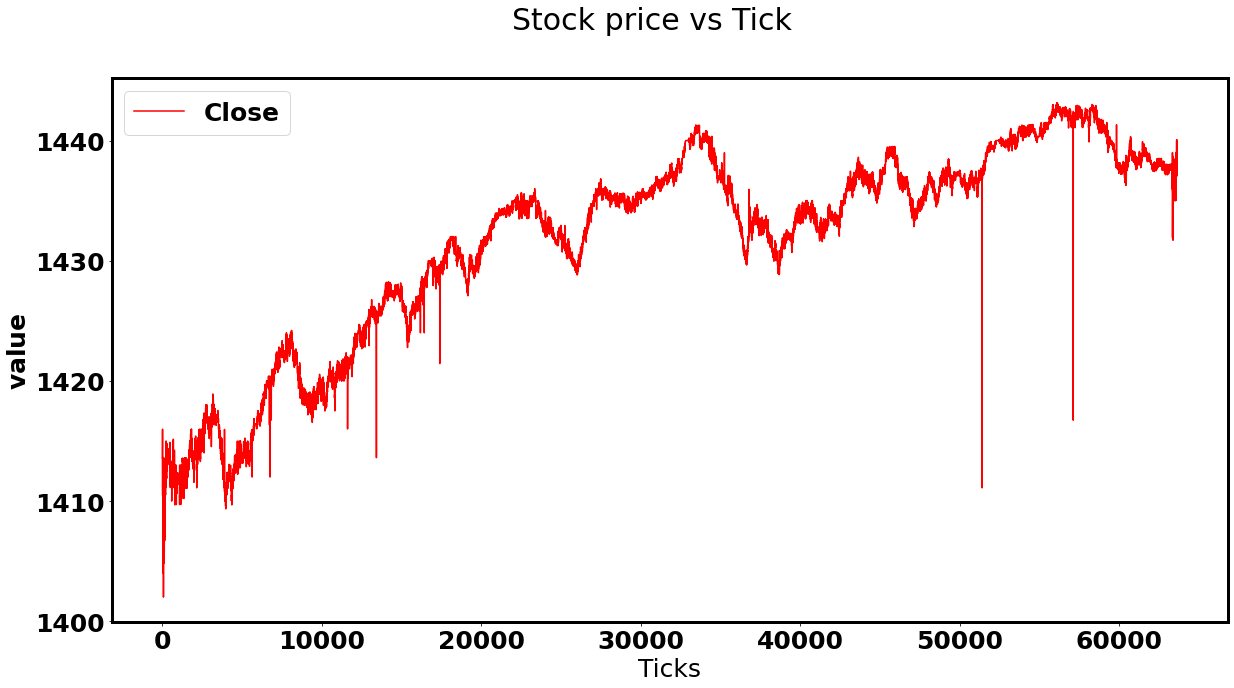

In [5]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)

#plt.plot(df_hf["Open"],"k",label= "Open")
plt.plot(df_hf["Close"],"r",label= "Close")

plt.xlabel("Ticks")
plt.ylabel(r"${\rm value}$")
plt.suptitle("Stock price vs Tick")
plt.legend()

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20,10)

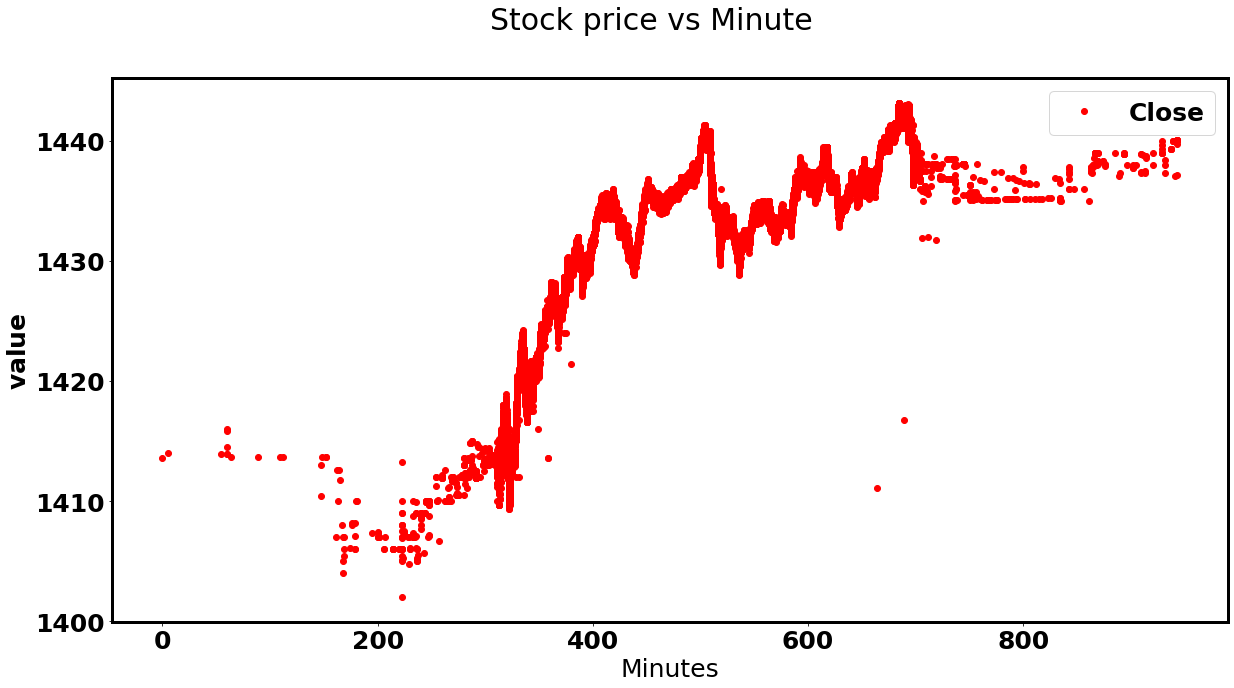

In [6]:
df_hf["DateTime"] = pd.to_datetime(df_hf["DateTime"], format="%Y-%m-%d %H:%M:%S:%f")
delta_min = (df_hf["DateTime"]-df_hf["DateTime"][0]).dt.total_seconds()//60


import matplotlib
from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)

#plt.plot(delta_min,df_hf["Open"],"kx",label= "Open")
plt.plot(delta_min,df_hf["Close"],"ro",label= "Close")

plt.xlabel("Minutes")
plt.ylabel(r"${\rm value}$")
plt.suptitle("Stock price vs Minute")
plt.legend()

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20,10)

In [7]:
delta_split = int(df_hf.shape[0]*0.7)
train_hf = df_hf[:delta_split]
test_hf = df_hf[delta_split:]
print("Training date length hf",len(train_hf),"testing date length hf", len(test_hf))

Training date length hf 44547 testing date length hf 19092


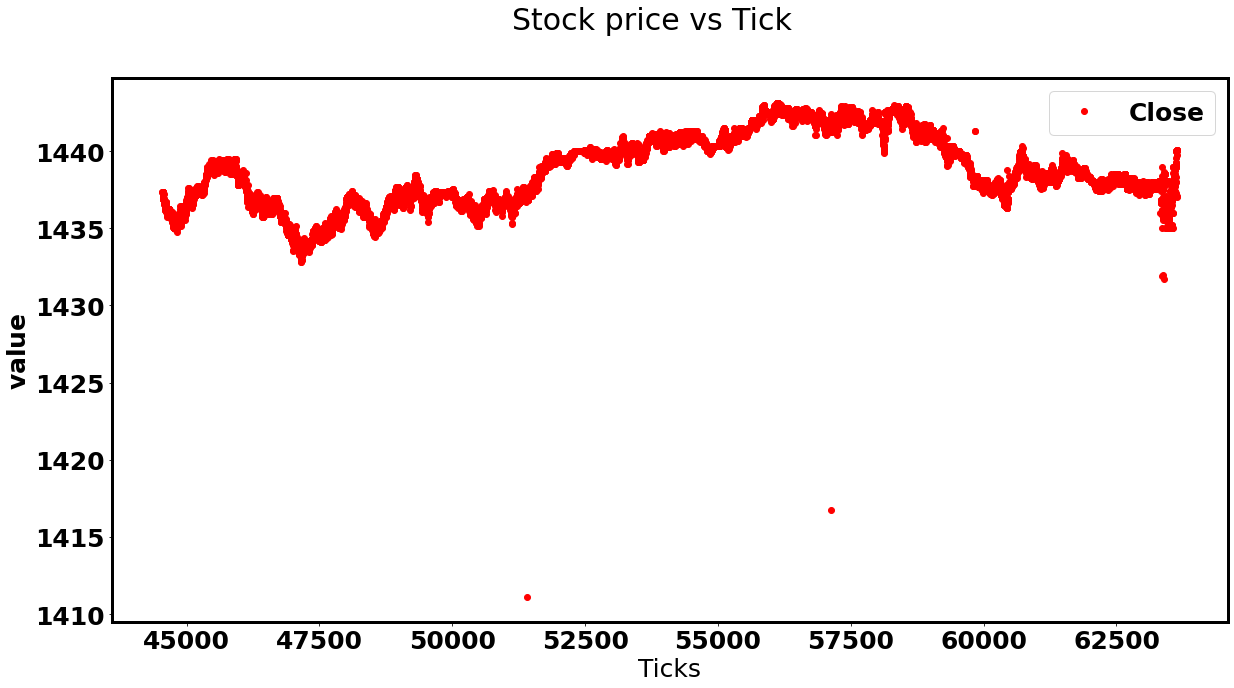

In [8]:
import matplotlib
from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)

plt.plot(test_hf["Close"],"ro",label= "Close")

plt.xlabel("Ticks")
plt.ylabel(r"${\rm value}$")
plt.suptitle("Stock price vs Tick")
plt.legend()

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20,10)

In [9]:
def profit_calculator(data,actions):
    ans = 0
    # For Google it's 0.5 cent transaction fee
    ratio = 0.005
    history = []
    
    for i in range(len(data)):
        if actions[i]==0:
            pass
        elif actions[i]==1:
            history.append(data[i])
        else:
            ans += len(history)*data[i]-np.sum(history)-len(history)*ratio
            history = []
    return ans

In [10]:
window_size=30

threthold = 5


def sliding_window(data):
    actions = []
    for i in range(len(data)):
        temp = data[max(0,i-window_size):i]
        if len(temp)>0 and data[i]<np.nanpercentile(temp,threthold):
            # buy
            actions.append(1)
        elif len(temp)>0 and data[i]>np.nanpercentile(temp,100-threthold):
            actions.append(2)
        else:
            actions.append(0)
    return actions

            
actions = sliding_window(data =test_hf["Close"].values)

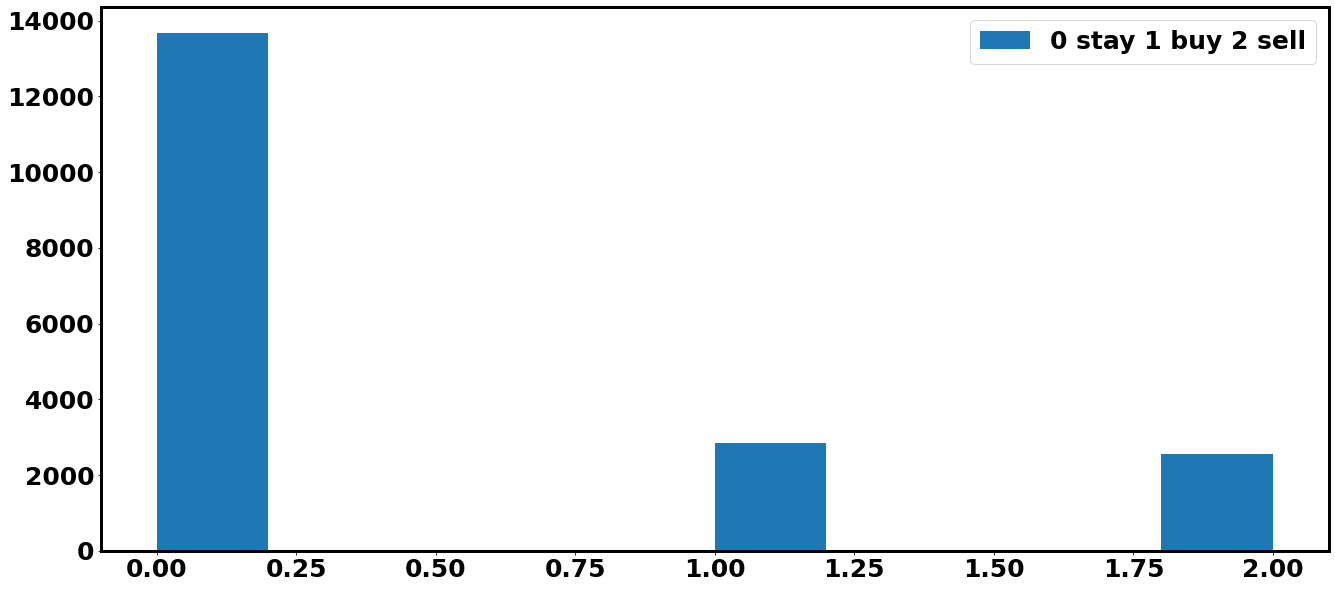

In [11]:
plt.hist(actions,label = "0 stay 1 buy 2 sell")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(22,10)
plt.legend()
plt.show()

In [12]:
import copy

window_size = 30

threthold_a = 0

threthold_p = 0.01

max_history_length = 10

def helper(data,actions):
    ans = 0
    max_history = 0
    mean_d = np.nanmean(data)
    actions_modified = copy.copy(actions)
    
    # For Google it's 0.5% transaction fee
    ratio = 0.005
    history = []
    
    for i in range(len(data)):
        if actions[i]==0:
            pass
        elif actions[i]==1:
            temp = actions[max(0,i-window_size//2):i]
            temp = list(temp)
            #print(temp)
            if temp.count(1)>threthold_a/100*len(temp) and len(history)<max_history_length:
                # buy
                history.append(data[i])
            else:
                # stay
                actions_modified[i]=0
                
        else:
            p = len(history)*data[i]-np.sum(history)-len(history)*0.005
            if p>mean_d*threthold_p/100:
                # sell:
                ans += p 
                history = []
            else:
                # stay
                actions_modified[i]=0
            
    return ans,actions_modified

profit,test_acts_mod = helper(data=test_hf["Close"].values,actions=actions)

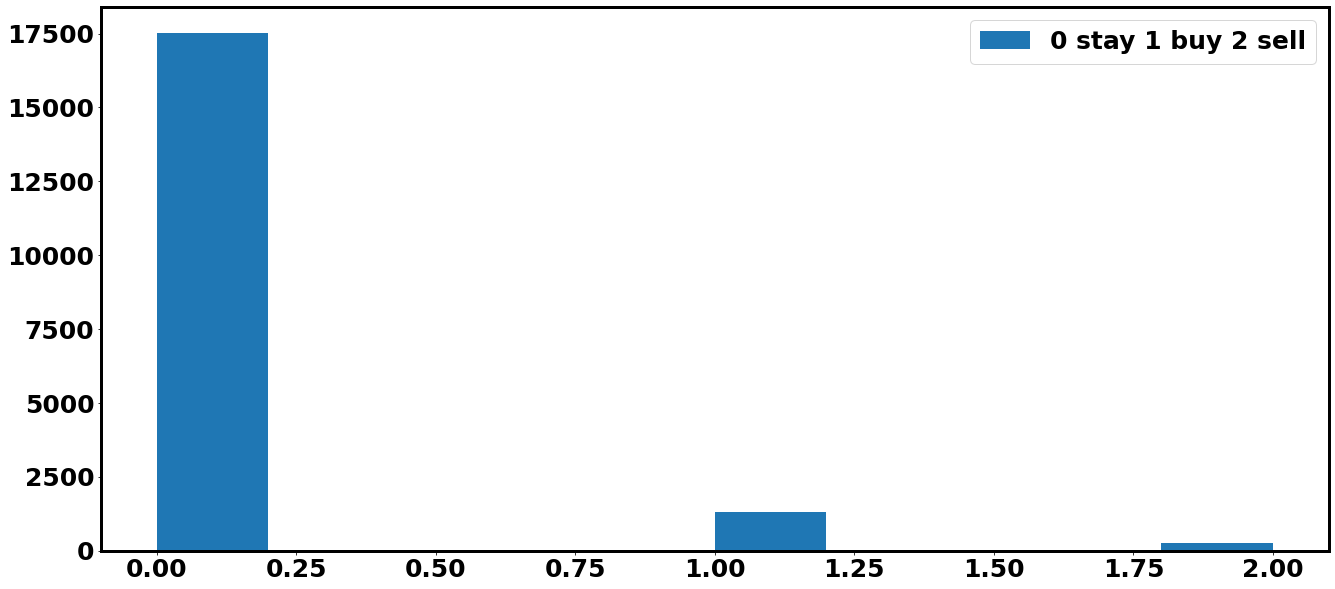

In [13]:
plt.hist(test_acts_mod,label = "0 stay 1 buy 2 sell")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(22,10)
plt.legend()
plt.show()

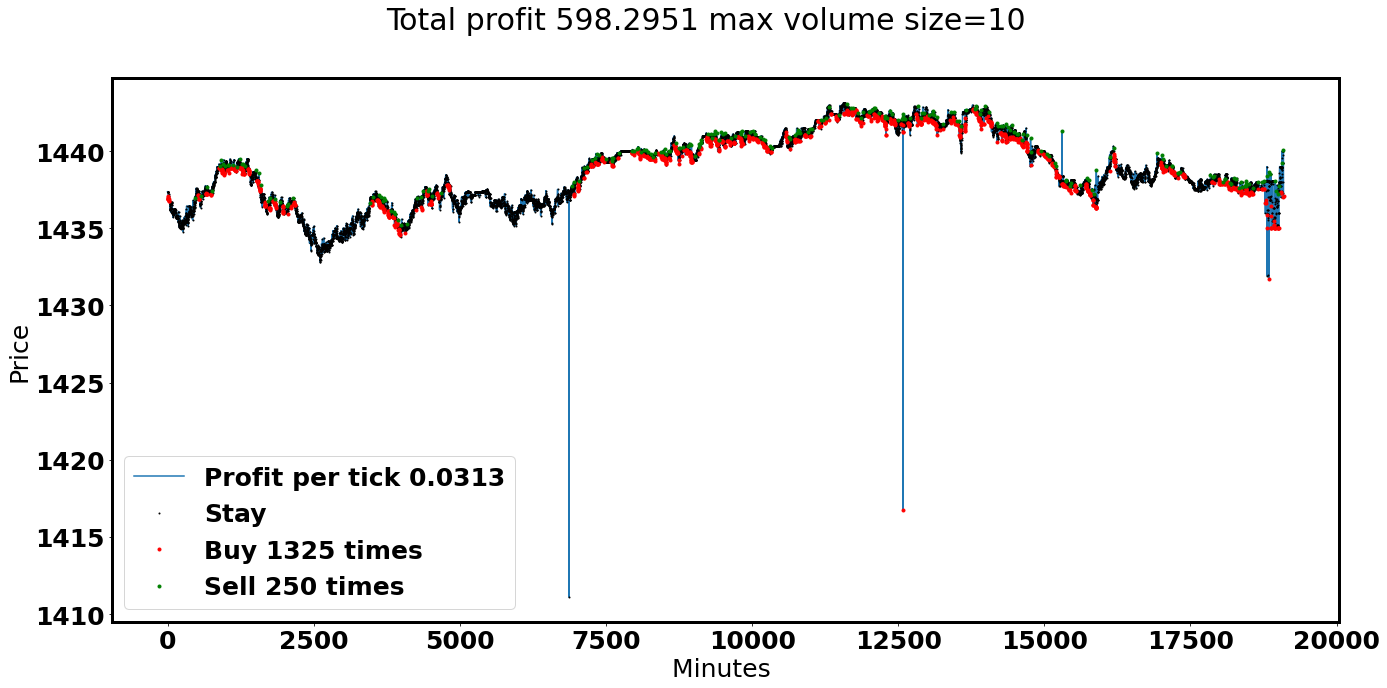

In [14]:
plt.subplot(1,1,1)
y = test_hf["Close"].values

test_acts_mod = np.array(test_acts_mod)
m0 = test_acts_mod==0
m1 = test_acts_mod==1
m2 = test_acts_mod==2
plt.plot(np.arange(0,len(y),1),y,label = "Profit per tick %.4f"%(profit/len(y)))
plt.plot(np.arange(0,len(y),1)[m0],y[m0],"ko",label = "Stay",markersize=1)
plt.plot(np.arange(0,len(y),1)[m1],y[m1],"ro",label = "Buy %d times"%len(y[m1]),markersize=3)
plt.plot(np.arange(0,len(y),1)[m2],y[m2],"go",label = "Sell %d times"%len(y[m2]),markersize=3)

plt.xlabel("Minutes ")
plt.ylabel("Price")
plt.suptitle("Total profit %.4f max volume size=%d"%(profit,max_history_length))



fig = matplotlib.pyplot.gcf()

fig.set_size_inches(22,10)
plt.legend()
plt.show()

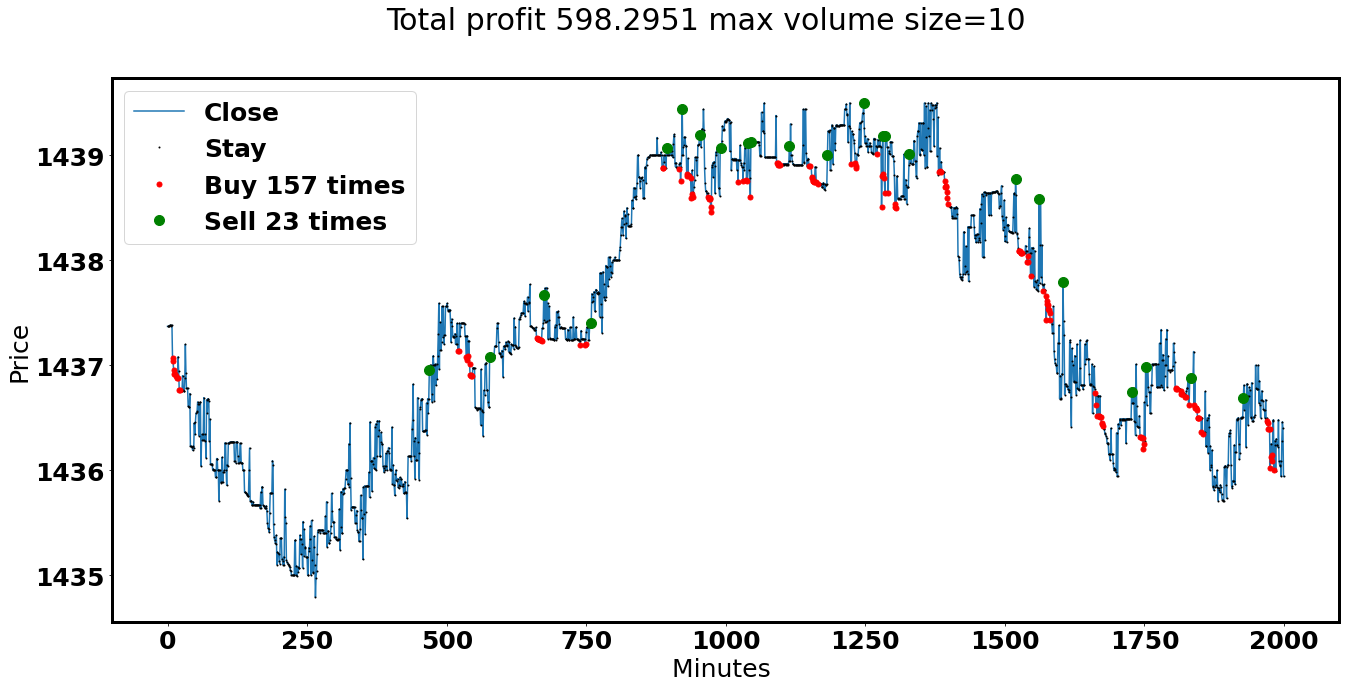

In [15]:
show_tick_length = 2000

plt.subplot(1,1,1)
y = test_hf["Close"].values[:show_tick_length]

test_acts_mod = np.array(test_acts_mod)[:show_tick_length]
m0 = test_acts_mod==0
m1 = test_acts_mod==1
m2 = test_acts_mod==2

plt.plot(np.arange(0,len(y),1),y,label = "Close")
plt.plot(np.arange(0,len(y),1)[m0],y[m0],"ko",label = "Stay",markersize=1)
plt.plot(np.arange(0,len(y),1)[m1],y[m1],"ro",label = "Buy %d times"%len(y[m1]),markersize=5)
plt.plot(np.arange(0,len(y),1)[m2],y[m2],"go",label = "Sell %d times"%len(y[m2]),markersize=10)

plt.xlabel("Minutes ")
plt.ylabel("Price")
plt.suptitle("Total profit %.4f max volume size=%d"%(profit,max_history_length))



fig = matplotlib.pyplot.gcf()

fig.set_size_inches(22,10)
plt.legend()
plt.show()